# 特異値分解

In [2]:
import numpy as np
import pandas as pd
import japanize_matplotlib
import matplotlib.pyplot as plt

In [8]:
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF

In [18]:
# -1〜+1の間に規格化
def normalize(score):
    norm = (score-score.min())/(score.max()-score.min()) # 0-1に規格化
    norm = norm * 2
    norm = norm - np.mean(norm, axis=0)
    return norm

In [19]:
# 位相整列の実装(指導教員から提供された関数)
def alignment(x):
    fft = np.fft.fft(x)
    fft_phase = np.angle(fft)
    fft_abs = np.abs(fft)[:-1] # -1はあったほうが良さそう。
    disp = fft_phase[np.argmax(fft_abs)] * len(x) / (2 * np.pi)
    disp = int(- disp) % len(x)
    return np.tile(x, 2)[disp:disp+len(x)]

In [3]:
# 使うデータは1036冊分の小説データの感情スコア値
SCORE_PATH = 'data/all_score_0630.csv'

In [3]:
# pandas dataframeとして読み込む
score_df = pd.read_csv(SCORE_PATH, index_col=0)
score_df.head()

,S00,S01,S02,S03,S04,S05,S06,S07,S08,S09,...,S90,S91,S92,S93,S94,S95,S96,S97,S98,S99
13,0.791536,0.737968,0.829343,0.794293,0.724665,0.707668,0.620669,0.607199,0.584499,0.626389,...,0.754139,0.782878,0.784226,0.576965,0.534152,0.601299,0.612696,0.611167,0.664706,0.736535
24,0.749562,0.727724,0.721075,0.648729,0.764811,0.627247,0.634754,0.640822,0.792777,0.844474,...,0.690379,0.640809,0.828280,0.806064,0.754045,0.906671,0.896347,0.869153,0.901117,0.933473
30,0.473785,0.473785,0.652944,0.622040,0.663769,0.799352,0.982744,0.966812,0.851591,0.907304,...,0.101549,0.142406,0.285570,0.270750,0.320434,0.441094,0.464494,0.548101,0.610829,0.517892
41,0.900899,0.952689,1.000000,0.928408,0.802310,0.760143,0.699925,0.759109,0.660739,0.726829,...,0.094422,0.246499,0.291265,0.373439,0.445357,0.450839,0.390509,0.337263,0.402609,0.459209
47,0.742317,0.836033,0.890097,0.911625,0.967501,0.967501,0.972570,0.982321,1.000000,0.929571,...,0.202141,0.256933,0.256933,0.243298,0.175068,0.204548,0.171354,0.173879,0.108680,0.023454


In [4]:
scores = score_df.to_numpy()
scores[:5].shape

(5, 100)

In [5]:
# 平均値を０にしておく
A = scores - scores.mean(axis=0)
A.shape

(1036, 100)

In [20]:
# 位相整列の実装(指導教員から提供された間数)
def alignment(x):
    fft = np.fft.fft(x)
    fft_phase = np.angle(fft)
    fft_abs = np.abs(fft)[:-1] # -1はあったほうが良さそう。
    disp = fft_phase[np.argmax(fft_abs)] * len(x) / (2 * np.pi)
    disp = int(- disp) % len(x)
    return np.tile(x, 2)[disp:disp+len(x)]

## PCA

In [10]:
from sklearn.decomposition import PCA

model = PCA()
x = model.fit_transform(A)
x.shape

(1036, 100)

In [11]:
model.components_.shape

(100, 100)

In [13]:
# 寄与率(Top 10)
model.explained_variance_ratio_[:10]

array([0.2803353 , 0.20929572, 0.14457506, 0.10477838, 0.06483455,
       0.05243667, 0.02811643, 0.01357077, 0.01220571, 0.01077935])

In [14]:
# 累積寄与率
max_comp = 20
cumulative_contribution_ratio = [np.sum(model.explained_variance_ratio_[0:i]) for i in range(1, max_comp+1)]
cumulative_contribution_ratio = np.array(cumulative_contribution_ratio)

In [15]:
# 累積寄与率が9割以下
cumulative_contribution_ratio[cumulative_contribution_ratio<=0.9]

array([0.2803353 , 0.48963102, 0.63420607, 0.73898445, 0.80381901,
       0.85625568, 0.88437211, 0.89794288])

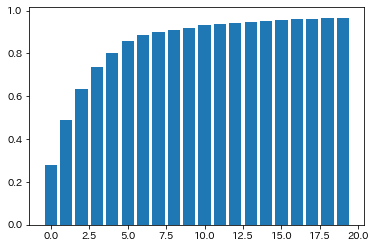

In [17]:
# 累積寄与率の表示
plt.bar(np.arange(max_comp), cumulative_contribution_ratio)
plt.show()

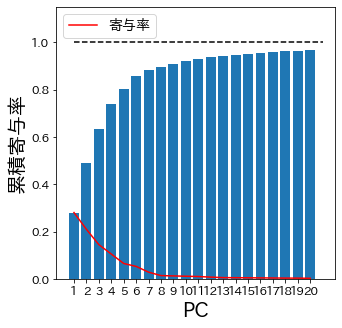

In [18]:
#累積寄与率と寄与率を棒グラフで可視化する
plt.figure(figsize=(5,5))
plt.bar(np.arange(1,max_comp+1),cumulative_contribution_ratio)
plt.plot(np.arange(1,max_comp+1),model.explained_variance_ratio_[:max_comp],color='red',label='寄与率')
plt.xticks(np.arange(1,max_comp+1))
plt.xlabel('PC', size=20)
plt.ylabel('累積寄与率',size=20)
plt.legend(loc='upper left', fontsize=14)
plt.ylim(0,1.15)
plt.tick_params(labelsize=12)
plt.hlines(1,1,21,color='black',linestyles='dashed')
plt.show()

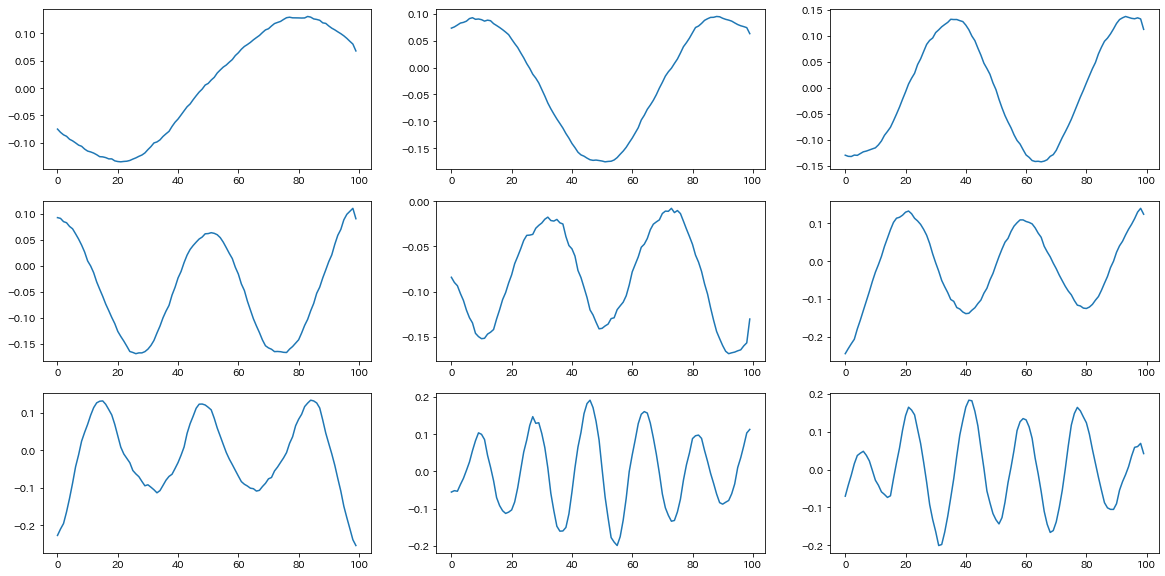

In [19]:
plt.figure(figsize=(20, 10))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.plot(model.components_[i-1])
plt.show()

## PCA2

numpyで実施(参考:https://note.com/noa813/n/na6116484e1b1)

In [48]:
# 平均値を０にしておく
A = scores - scores.mean(axis=0)
A.shape

(1036, 100)

In [49]:
# 共分散行列を作成
cov = np.cov(A, rowvar=False)
cov[:5, :5]

array([[0.08908588, 0.084537  , 0.07948481, 0.07414913, 0.06870453],
       [0.084537  , 0.08476092, 0.08038352, 0.07528857, 0.06999226],
       [0.07948481, 0.08038352, 0.08088845, 0.07660266, 0.0714982 ],
       [0.07414913, 0.07528857, 0.07660266, 0.0775194 , 0.07337842],
       [0.06870453, 0.06999226, 0.0714982 , 0.07337842, 0.07422896]])

In [50]:
# 固有値・固有ベクトルを計算
s, v = np.linalg.eig(cov)
s.shape, v.shape

((100,), (100, 100))

In [51]:
# 固有値の大きい順に固有ベクトルを並べ替え
s_index = np.argsort(s)[::-1]
s_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 58, 62, 64, 65, 68, 69, 75,
       70, 71, 76, 82, 84, 86, 91, 87, 88, 93, 99, 92, 94, 90, 97, 98, 95,
       89, 85, 79, 80, 83, 81, 96, 78, 77, 74, 73, 72, 67, 66, 63])

In [52]:
v_ = v[:, s_index]

In [53]:
# n_components個の固有ベクトルを取得
n_components = 2
components = v_[:,:n_components]

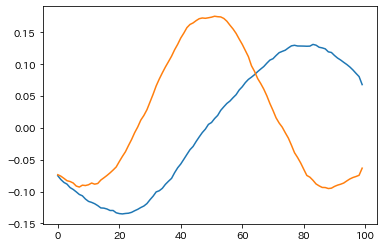

In [54]:
plt.plot(components.T[0])
plt.plot(components.T[1])

In [88]:
# 寄与率表示
np.set_printoptions(suppress=True) 
s_index = np.argsort(s)[::-1]
ratio = s[s_index]/np.sum(s[s_index])
ratio[:10]

array([0.2803353 , 0.20929572, 0.14457506, 0.10477838, 0.06483455,
       0.05243667, 0.02811643, 0.01357077, 0.01220571, 0.01077935])

<BarContainer object of 100 artists>

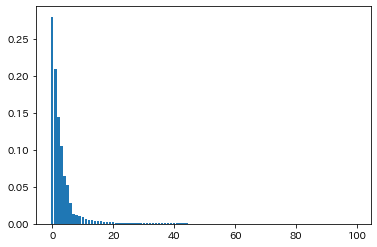

In [68]:
plt.bar(np.arange(ratio.shape[0]), ratio)

<BarContainer object of 20 artists>

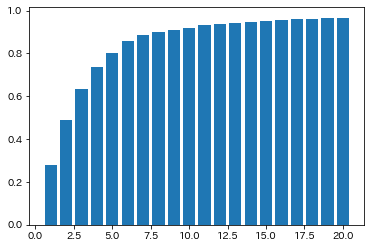

In [87]:
# 累積寄与率
cumulative_ratio = [np.sum(ratio[:i]) for i in np.arange(1, len(ratio)+1)]
n = 20
plt.bar(np.arange(1,n+1), cumulative_ratio[:n])

## SVD

$ A = USV^T = WV^T $

### 特異値分解を実施

In [6]:
np.mean(scores), np.max(scores), np.min(scores)

(0.5015698607040415, 1.0, 0.0)

In [36]:
# -1〜+1の間に規格化
A = normalize(A)
# A = (scores * 2)
# A = A - A.mean(axis=0)
A.shape

# 平均値を０にしておく
# A = scores - scores.mean(axis=0)
# A.shape

# 以下は標準化
# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler()
# A = ss.fit_transform(scores)
# A = (scores - scores.mean(axis=0))/scores.std(axis=0)
# A.shape

(1036, 100)

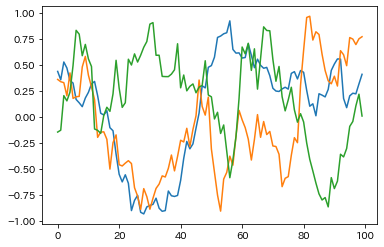

In [45]:
for i in np.arange(3):
    plt.plot(A[i,:])
plt.show()

In [46]:
np.max(A), np.min(A), np.mean(A), np.std(A)

(0.9828966002177144,
 -1.0171033997822851,
 -1.3044048895499426e-17,
 0.48457875445654575)

In [47]:
# 特異値分解(Singular Value Decomposition)
U, s, Vh = np.linalg.svd(A, full_matrices=False)

In [48]:
# 戻り値の形を確認
U.shape, s.shape, Vh.shape

((1036, 100), (100,), (100, 100))

$s$は対角成分のみのベクトルとなっている

In [49]:
# W は U x Sで求める
W = U * s
W.shape

(1036, 100)

In [50]:
# 対角行列に変換して内積をとっても同じ
W_2 = U @ np.diag(s)
# 比較
np.all(np.equal(W, W_2))

True

### 重要な指標の把握

参考:https://dev.to/elldora/how-to-plot-feature-importance-using-truncated-svd-166n

### 特徴量の抽出

$ A = USV^T = WV^T $

$ V^T $ の行に特徴があらわれる．各行(ベクトル)を mode と呼ぶ．

参考にしたのは先行研究（https://db-event.jpn.org/deim2019/post/papers/350.pdf）

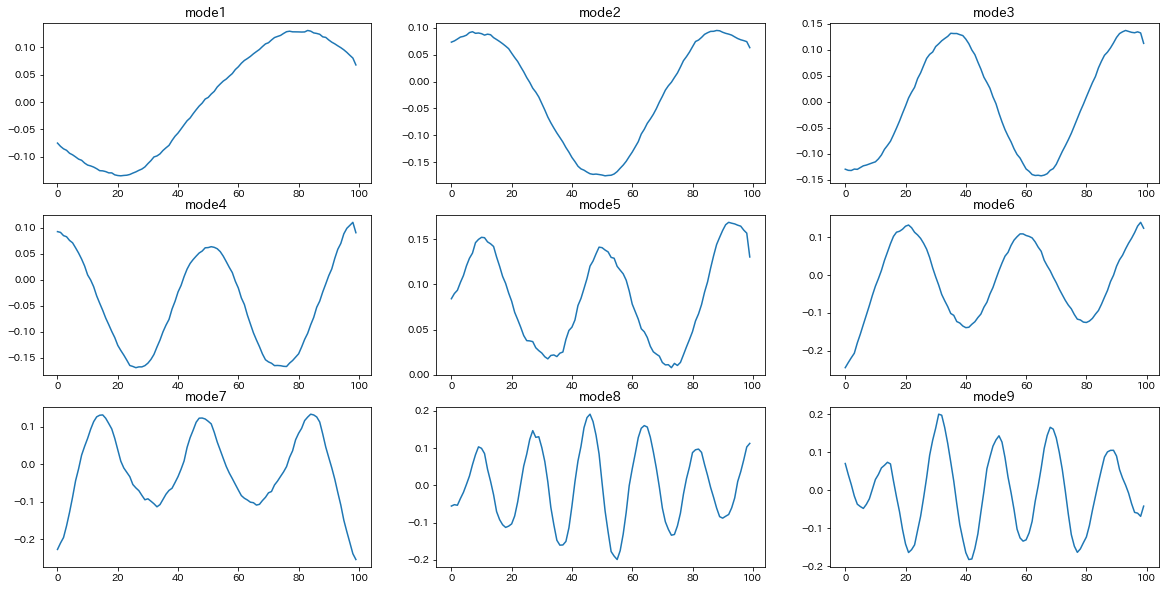

In [51]:
# mode1 - mode9を表示する
plt.figure(figsize=(20, 10))
for i in range(1, 10):
    ax = plt.subplot(3, 3, i)
    ax.set_title(f'mode{i}', fontsize=13)
    ax.plot(Vh[i-1])
plt.show()

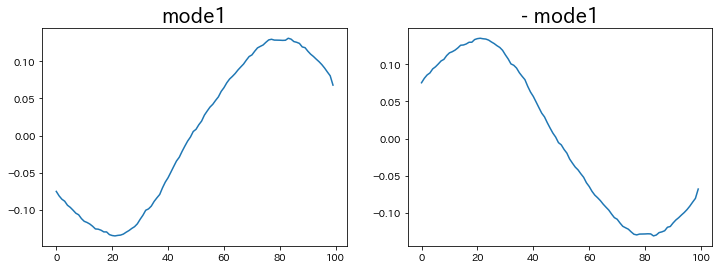

In [52]:
# mode1 を 上下反転させたものを -mode1とする
plt.figure(figsize=(12, 4))

ax1 = plt.subplot(1, 2, 1)
ax1.set_title('mode1', fontsize=20)
ax1.plot(Vh[0])

ax2 = plt.subplot(1, 2, 2)
ax2.set_title('- mode1', fontsize=20)
ax2.plot(-Vh[0])

plt.show()


行列 $W$ の 各行の絶対値の最大値を求める．その最大値がある要素の要素番号に対応する mode が，その小説の特徴を表しているものといえる．

In [53]:
# 各行の各要素の絶対値の最大がある要素番号を取得
max_element_ids = np.argmax(np.abs(W), axis=1)
max_element_ids, max_element_ids.shape
mode_ids = max_element_ids.copy()

In [54]:
# 各行の絶対値最大を取得
max_elements = [W[i, max_element_ids[i]] for i in range(len(max_element_ids))]
print(list(max_elements[:5]))
mode_flg = [1 if max_elements[i] >= 0 else -1 for i in range(len(max_elements))]
print(list(mode_flg[:5]), len(mode_flg))

[3.1532671310603324, 2.6583675375469897, -1.9782252392027184, -3.23844444803764, -3.612504561819977]
[1, 1, -1, -1, -1] 1036


In [55]:
print(mode_ids[:5], len(mode_ids)) # 対応するmode
print(mode_flg[:5], len(mode_flg)) # mode(i),-mode(i)

[0 1 0 2 2] 1036
[1, 1, -1, -1, -1] 1036


In [57]:
# Vhを正規化
Vh_norm = normalize(Vh)
# Vh_norm = (Vh - Vh.min(axis=0))/(Vh.max(axis=0) - Vh.min(axis=0))
# Vhを-1〜+1の間にする
# Vh_norm = (Vh_norm * 2) - 1
# Vh_norm.min(), Vh_norm.max()

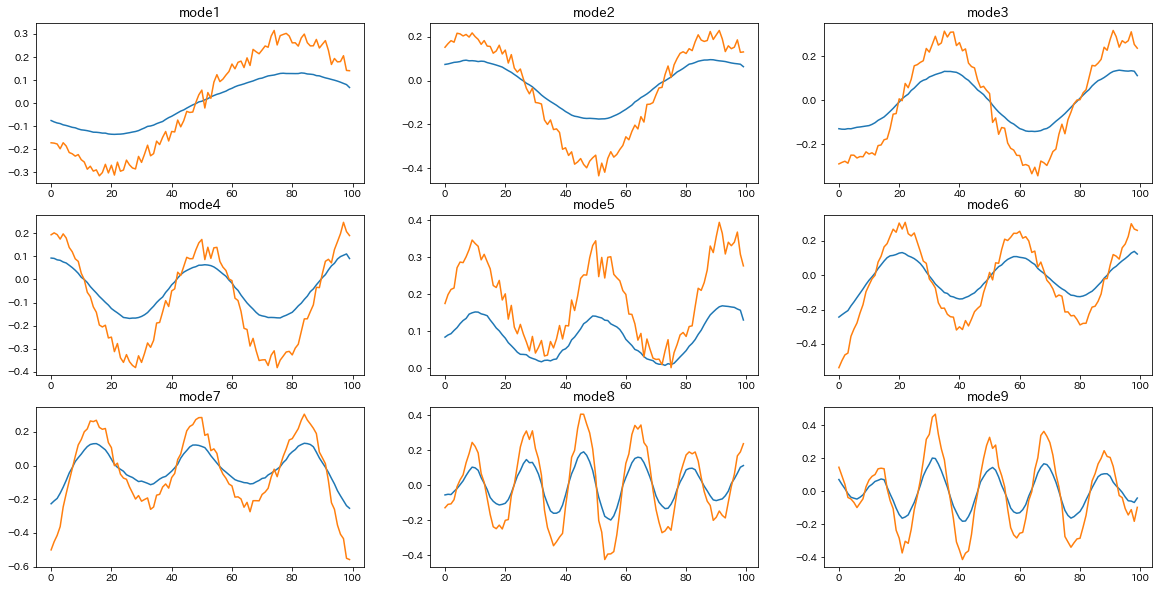

In [61]:
# mode1 - mode9を表示する
plt.figure(figsize=(20, 10))
for i in range(1, 10):
    ax = plt.subplot(3, 3, i)
    ax.set_title(f'mode{i}', fontsize=13)
    ax.plot(Vh[i-1])
    ax.plot(Vh_norm[i-1])
plt.show()

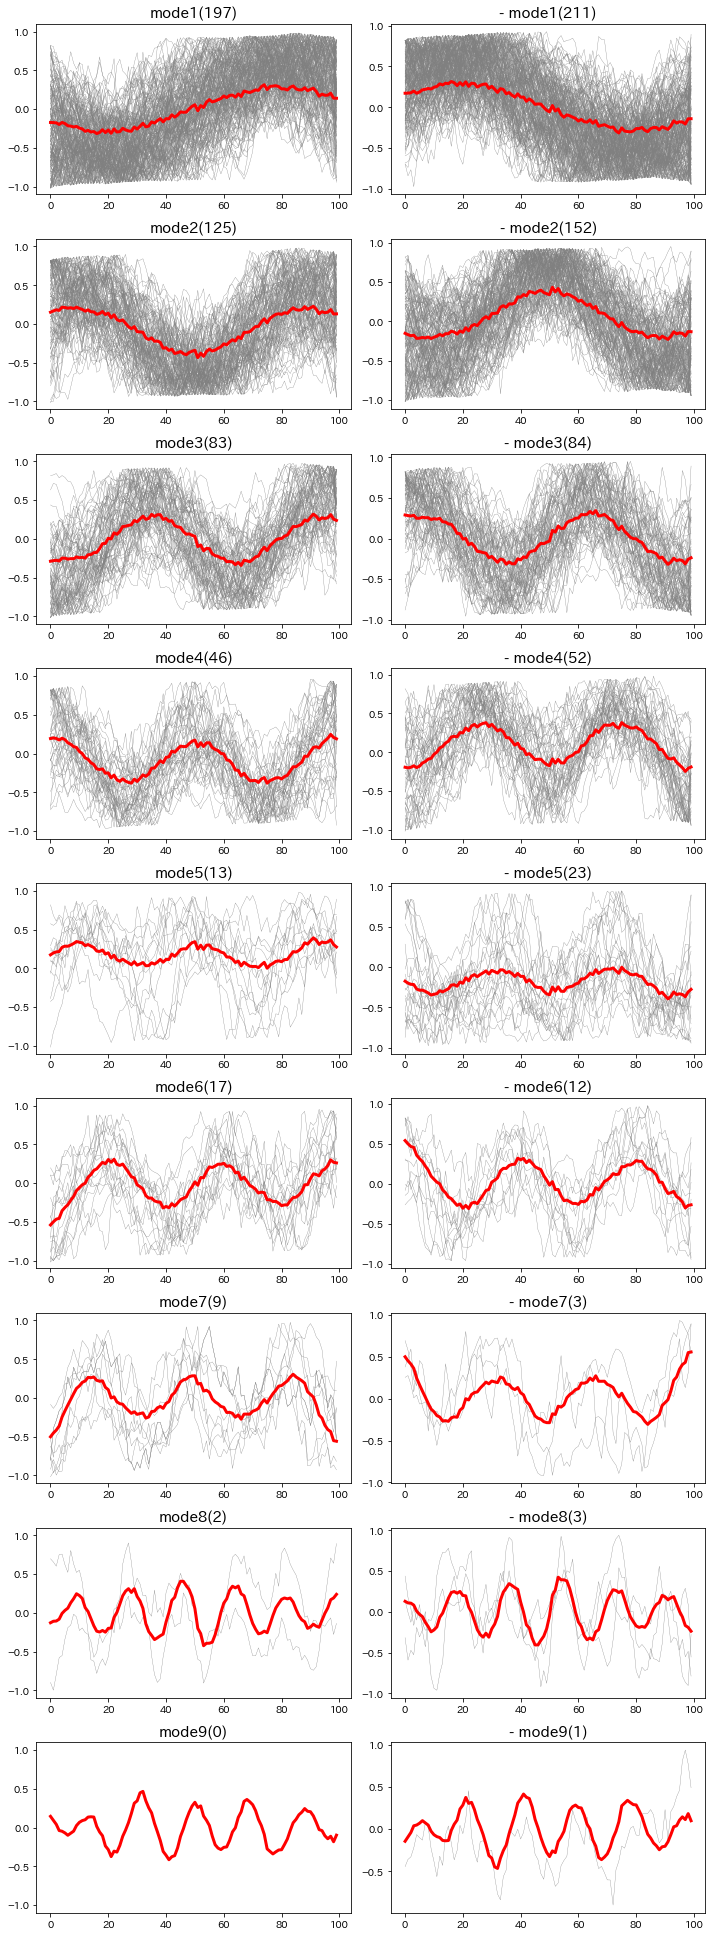

<Figure size 864x288 with 0 Axes>

In [60]:
# 感情曲線の描画
mode_num = 9 # モード数(plotの行数)
min_y = -1.1
max_y = 1.1
fig, axes = plt.subplots(mode_num, 2, figsize=(10, mode_num*3), tight_layout=True)
plt.figure(figsize=(12, 4))

count = np.zeros((mode_num, 2))
for row in np.arange(mode_num):
    for id in range(len(mode_ids)):
        if mode_ids[id] == row:
            col = 0  if mode_flg[id] >= 0 else 1
            count[row][col] += 1
            axes[row, col].plot(A[id], c='gray', linewidth=0.3)
    axes[row, 0].set_title(f'mode{row+1}({int(count[row][0])})', fontsize=15)
    axes[row, 0].set_ylim(min_y, max_y)
    axes[row, 0].plot(Vh_norm[row], c='red', linewidth=3)
    axes[row, 1].set_title(f'- mode{row+1}({int(count[row][1])})', fontsize=15)
    axes[row, 0].set_ylim(min_y, max_y)
    axes[row, 1].plot(-Vh_norm[row], c='red', linewidth=3)

plt.show()


In [70]:
# 変数整理
print(max_element_ids[:5]) # 各行の最大値がある要素番号
print(mode_ids[:5])        # 同上
print(max_elements[:5])    # 各行の最大値
print(mode_flg[:5])        # 上の最大値が正:1,負:-1

[0 1 3 2 2]
[0 1 3 2 2]
[6.909421705969634, 5.390713203815001, -4.1898092617571425, -6.712983954601329, -7.6154906762473225]
[1, 1, -1, -1, -1]


In [71]:
for i, mode_id in enumerate(mode_ids):
    print(i, mode_id, max_elements[i], mode_flg[i])
    if i > 10:
        break

0 0 6.909421705969634 1
1 1 5.390713203815001 1
2 3 -4.1898092617571425 -1
3 2 -6.712983954601329 -1
4 2 -7.6154906762473225 -1
5 5 -4.175908188678685 -1
6 1 8.220354752680052 1
7 1 6.394628483311513 1
8 0 -9.564226320361792 -1
9 2 8.060303019835045 1
10 1 -5.730055413041827 -1
11 3 -7.576934235528313 -1


## SVD2

上の方法だと，入力がなんであれサインカーブになるとの指摘を指導教員から受けた．

(https://www.jstage.jst.go.jp/article/tjsai/25/4/25_4_540/_pdf)

In [62]:
# 位相整列の実装(指導教員から提供された関数)
def alignment(x):
    fft = np.fft.fft(x)
    fft_phase = np.angle(fft)
    fft_abs = np.abs(fft)[:-1] # -1はあったほうが良さそう。
    disp = fft_phase[np.argmax(fft_abs)] * len(x) / (2 * np.pi)
    disp = int(- disp) % len(x)
    return np.tile(x, 2)[disp:disp+len(x)]

In [63]:
# −１〜１の間に規格化
A = normalize(scores)
# A = (scores - scores.mean(axis=0))/scores.std(axis=0)
A.shape

(1036, 100)

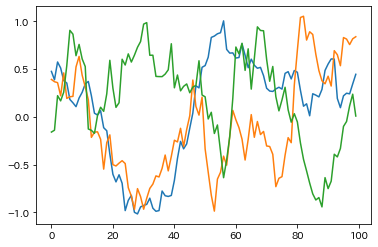

In [64]:
for i in np.arange(3):
    plt.plot(A[i])
plt.show()

In [65]:
# アライメント実行
A_alignment = []
for a in A:
    A_alignment.append(alignment(a))
A_alignment = np.array(A_alignment)

In [66]:
A_alignment.shape

(1036, 100)

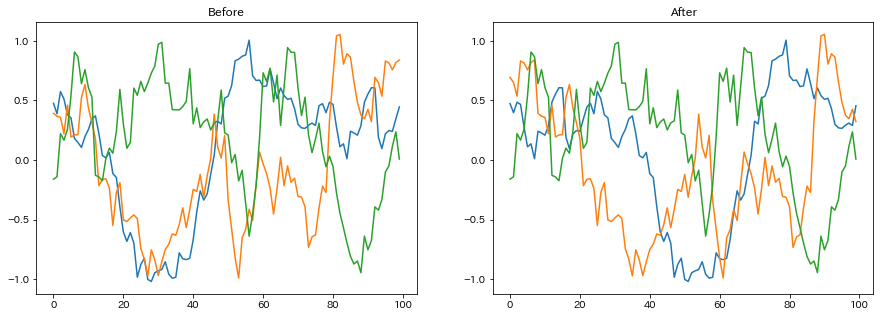

In [67]:
# 最初の数個を比較
n = 3
plt.figure(figsize=(15, 5))

# 位相整列前
for i in np.arange(n):
    ax = plt.subplot(1, 2, 1)
    ax.set_title('Before')
    ax.plot(A[i,:])

# 位相整列後
for i in np.arange(n):
    ax = plt.subplot(1, 2, 2)
    ax.set_title('After')
    ax.plot(A_alignment[i,:])

plt.show()

In [68]:
# 特異値分解(Singular Value Decomposition)
U2, s2, Vh2 = np.linalg.svd(A_alignment, full_matrices=False)

In [69]:
# W は U x Sで求める
W2 = U2 * s2
W2.shape

(1036, 100)

In [70]:
Vh2_alignment = normalize(Vh2)

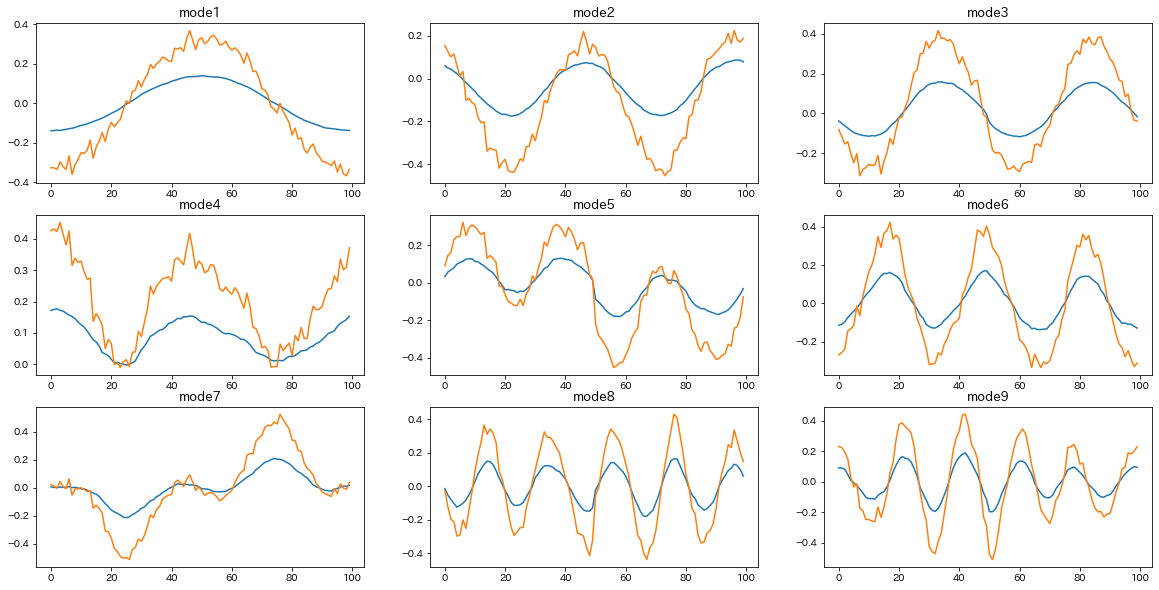

In [72]:
# mode1 - mode9を表示する
plt.figure(figsize=(20, 10))
for i in range(1, 10):
    ax = plt.subplot(3, 3, i)
    ax.set_title(f'mode{i}', fontsize=13)
    ax.plot(Vh2[i-1])
    ax.plot(Vh2_alignment[i-1])
plt.show()

In [73]:
# 各行の各要素の絶対値の最大がある要素番号を取得
max_element_ids2 = np.argmax(np.abs(W2), axis=1)
max_element_ids2, max_element_ids2.shape
mode_ids2 = max_element_ids2.copy()

In [74]:
# 各行の絶対値最大を取得
max_elements2 = [W2[i, max_element_ids2[i]] for i in range(len(max_element_ids2))]
print(list(max_elements2[:5]))
mode_flg2 = [1 if max_elements2[i] >= 0 else -1 for i in range(len(max_elements2))]
print(list(mode_flg2[:5]), len(mode_flg2))

[-4.163675141567761, -3.7603523464503454, -2.462108570293057, 2.610916982857933, 4.130872943390544]
[-1, -1, -1, 1, 1] 1036


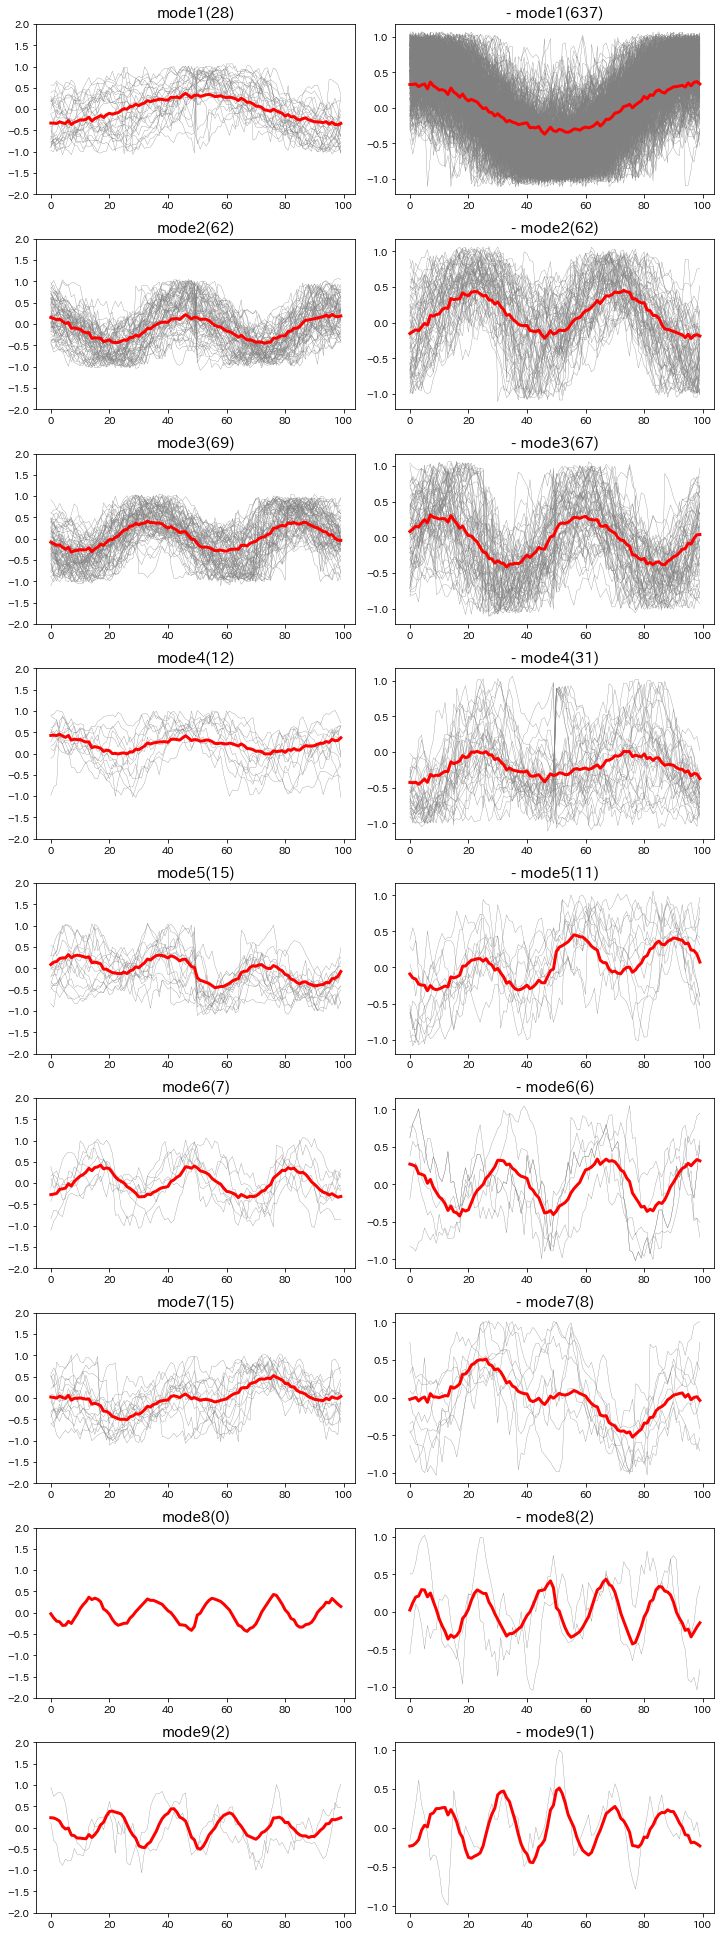

<Figure size 864x288 with 0 Axes>

In [75]:
# 感情曲線の描画
mode_num = 9 # モード数(plotの行数)
min_y = -2
max_y = 2
fig, axes = plt.subplots(mode_num, 2, figsize=(10, mode_num*3), tight_layout=True)
plt.figure(figsize=(12, 4))

count2 = np.zeros((mode_num, 2))
for row in np.arange(mode_num):
    for id in range(len(mode_ids2)):
        if mode_ids2[id] == row:
            col = 0  if mode_flg2[id] >= 0 else 1
            count2[row][col] += 1
            axes[row, col].plot(A_alignment[id], c='gray', linewidth=0.3)
    axes[row, 0].set_title(f'mode{row+1}({int(count2[row][0])})', fontsize=15)
    axes[row, 0].set_ylim(min_y, max_y)
    axes[row, 0].plot(Vh2_alignment[row], c='red', linewidth=3)
    axes[row, 1].set_title(f'- mode{row+1}({int(count2[row][1])})', fontsize=15)
    axes[row, 0].set_ylim(min_y, max_y)
    axes[row, 1].plot(-Vh2_alignment[row], c='red', linewidth=3)

plt.show()


In [76]:
rate = count2.sum(axis=1)/count2.sum()
rate

array([0.64251208, 0.11980676, 0.13140097, 0.04154589, 0.02512077,
       0.01256039, 0.02222222, 0.00193237, 0.00289855])

In [77]:
accum_rate = [np.sum(rate[0:i]) for i in np.arange(len(rate))]
accum_rate

[0.0,
 0.642512077294686,
 0.7623188405797101,
 0.893719806763285,
 0.9352657004830918,
 0.9603864734299516,
 0.9729468599033816,
 0.9951690821256038,
 0.9971014492753623]

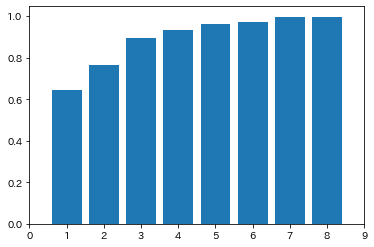

In [79]:
x = [i for i in np.arange(len(accum_rate))]
plt.bar(x, accum_rate)
plt.xlim(0, 9)
plt.show()

## NMF

- [信号処理論特論(東大の講義資料)](https://www.sp.ipc.i.u-tokyo.ac.jp/~saruwatari/SP-Grad2018_02.pdf)
- [非負値行列因子ぶんんかい](https://www.jstage.jst.go.jp/article/sicejl/51/9/51_835/_pdf)
- [非負値行列因子分解 NMF の基礎とデータ／信号解析への応用](http://www.kecl.ntt.co.jp/icl/signal/sawada/mypaper/829-833_9_02.pdf)

### Before alignment

In [4]:
# pandas dataframeとして読み込む
score_df = pd.read_csv(SCORE_PATH, index_col=0)
scores = score_df.to_numpy()
scores.shape

(1036, 100)

In [5]:
np.max(scores), np.min(scores)

(1.0, 0.0)

### 基本的な使い方

In [9]:
nmf = NMF()
nmf.fit(scores)
nmf_w = nmf.transform(scores)

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [10]:
nmf.components_.shape

(100, 100)

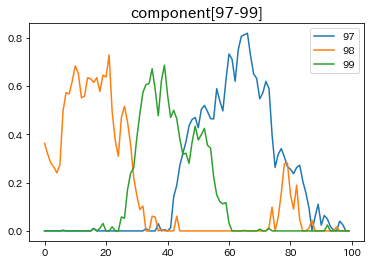

In [11]:
# 適当な場所から始めて5つのコンポーネントを表示
start = 97
for i in np.arange(5):
    if start+i >= 100:
        break
    plt.plot(nmf.components_[start+i,:], label=start+i)
    end = start+i
plt.title(f'component[{start}-{end}]', fontsize=15)
plt.legend()
plt.show()

In [12]:
# 最大の係数値のインデックス
nmf_w_argmax =  np.argmax(nmf_w, axis=1)
nmf_w_argmax

array([97, 19, 99, ..., 98,  0, 99])

In [13]:
# カウント
uniq, counts = np.unique(nmf_w_argmax, return_counts=True)
for u, count in zip(uniq, counts):
    print(u, count)

0 78
1 244
2 66
3 15
4 4
7 1
8 1
19 11
83 1
84 5
85 10
89 1
90 10
91 7
92 63
93 15
94 1
95 96
96 108
97 12
98 28
99 259


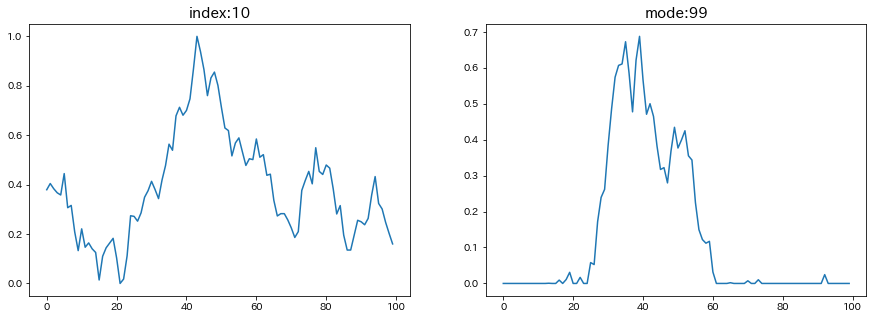

In [14]:
index = 10
plt.figure(figsize=(15,5))

ax1 = plt.subplot(1, 2, 1)
ax1.set_title(f'index:{index}', fontsize=15)
ax1.plot(scores[index, :])

ax2 = plt.subplot(1, 2, 2)
ax2.set_title(f'mode:{nmf_w_argmax[index]}', fontsize=15)
ax2.plot(nmf.components_[nmf_w_argmax[index],:])

### 様々なコンポーネント数

データ（スコア値）自体が０〜１の間（非負値）なので，そのまま使用する

In [15]:
from sklearn.decomposition import NMF

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/dec

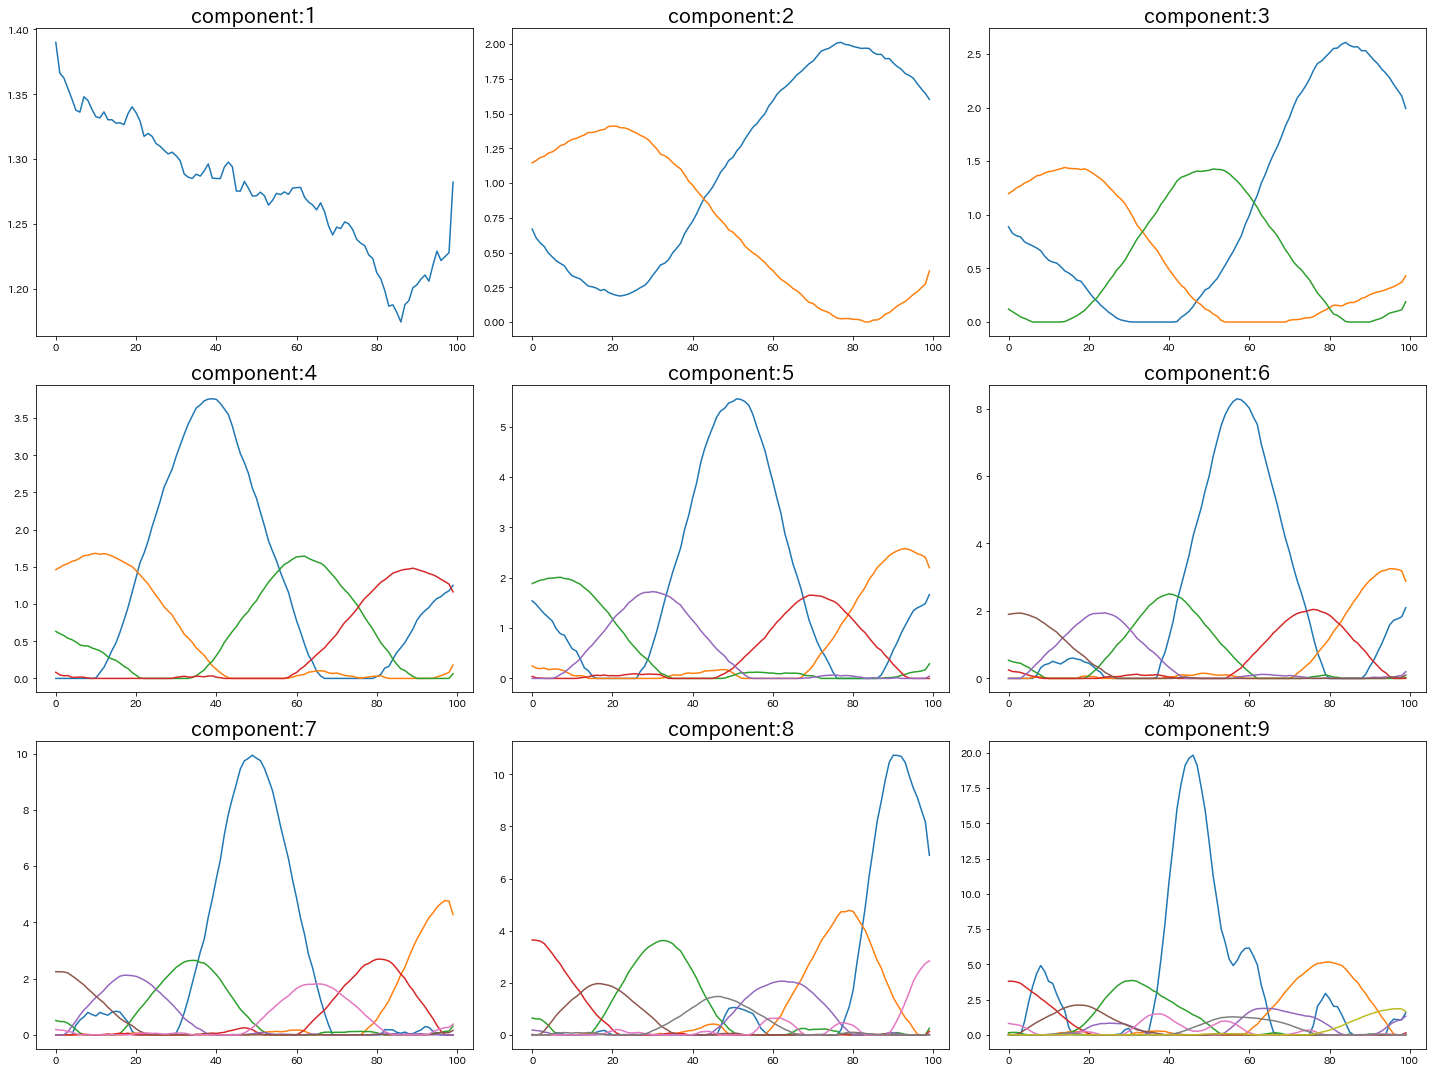

In [16]:
# コンポーネント数を変えて検証
nmf_models = []
for k in np.arange(1, 10):
    nmf = NMF(n_components=k)
    nmf.fit(scores)
    nmf_models.append(nmf)
    
# 視覚化
plt.figure(figsize=(20, 15))
for i in np.arange(len(nmf_models)):
    for j in np.arange(len(nmf_models[i].components_)):
        ax = plt.subplot(3, 3, i+1)
        ax.plot(nmf_models[i].components_[j])
    ax.set_title(f'component:{j+1}', fontsize=20)
plt.tight_layout()
plt.show()

### After alignment

In [20]:
# アライメント実行
alignment_scores = []
for score in scores:
    alignment_scores.append(alignment(score))
alignment_scores = np.array(alignment_scores)

In [21]:
alignment_scores.shape

(1036, 100)

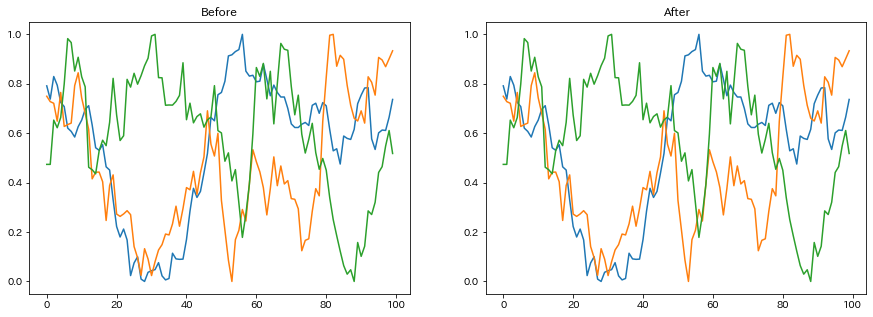

In [46]:
# 最初の数個を比較
n = 3
plt.figure(figsize=(15, 5))

# 位相整列前
for i in np.arange(n):
    ax1 = plt.subplot(1, 2, 1)
    ax1.set_title('Before')
    ax1.plot(scores[i,:])

# 位相整列後
for i in np.arange(n):
    ax2 = plt.subplot(1, 2, 2)
    ax2.set_title('After')
    ax2.plot(alignment_scores[i,:])

plt.show()

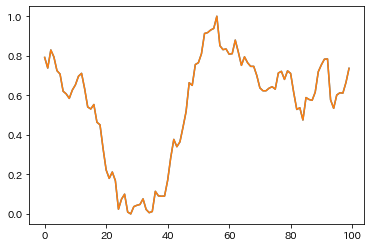

In [47]:
# 同じ小説をアライメント前後で比較
i = 0
plt.plot(scores[i,:])
plt.plot(alignment_scores[i,:])
plt.show()

どうも一致しているようにみえるので，アライメント前後の配列を比較してみる．

In [26]:
# アライメント前後の比較 -> 完全一致
np.all(scores == alignment_scores)

True

In [27]:
# −１〜１の間に規格化
A = normalize(scores)

In [28]:
# アライメント実行
alignment_scores = []
for a in A:
    alignment_scores.append(alignment(a))
alignment_scores = np.array(alignment_scores)

In [29]:
alignment_scores.shape

(1036, 100)

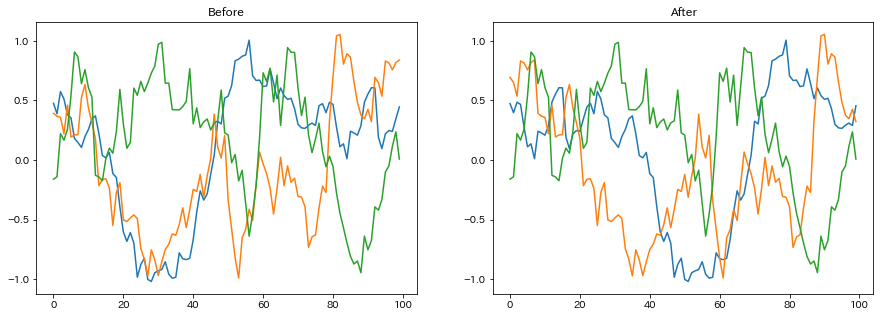

In [30]:
# 最初の数個を比較
n = 3
plt.figure(figsize=(15, 5))

# 位相整列前
for i in np.arange(n):
    ax1 = plt.subplot(1, 2, 1)
    ax1.set_title('Before')
    ax1.plot(A[i,:])

# 位相整列後
for i in np.arange(n):
    ax2 = plt.subplot(1, 2, 2)
    ax2.set_title('After')
    ax2.plot(alignment_scores[i,:])

plt.show()

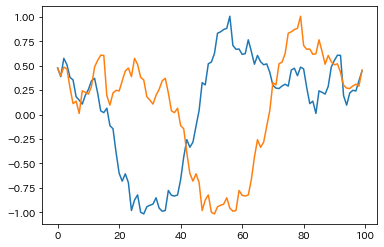

In [32]:
# 同じ小説をアライメント前後で比較
i = 0
plt.plot(A[i,:])
plt.plot(alignment_scores[i,:])
plt.show()

In [33]:
# アライメント後のデータを0~1の間で規格化する
alignment_A = (alignment_scores-alignment_scores.min())/(alignment_scores.max()-alignment_scores.min()) # 0-1に規格化

In [38]:
np.min(alignment_A)

0.0

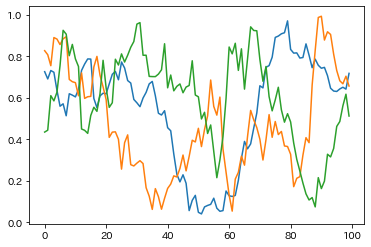

In [37]:
for i in np.arange(3):
    plt.plot(alignment_A[i])

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/dec

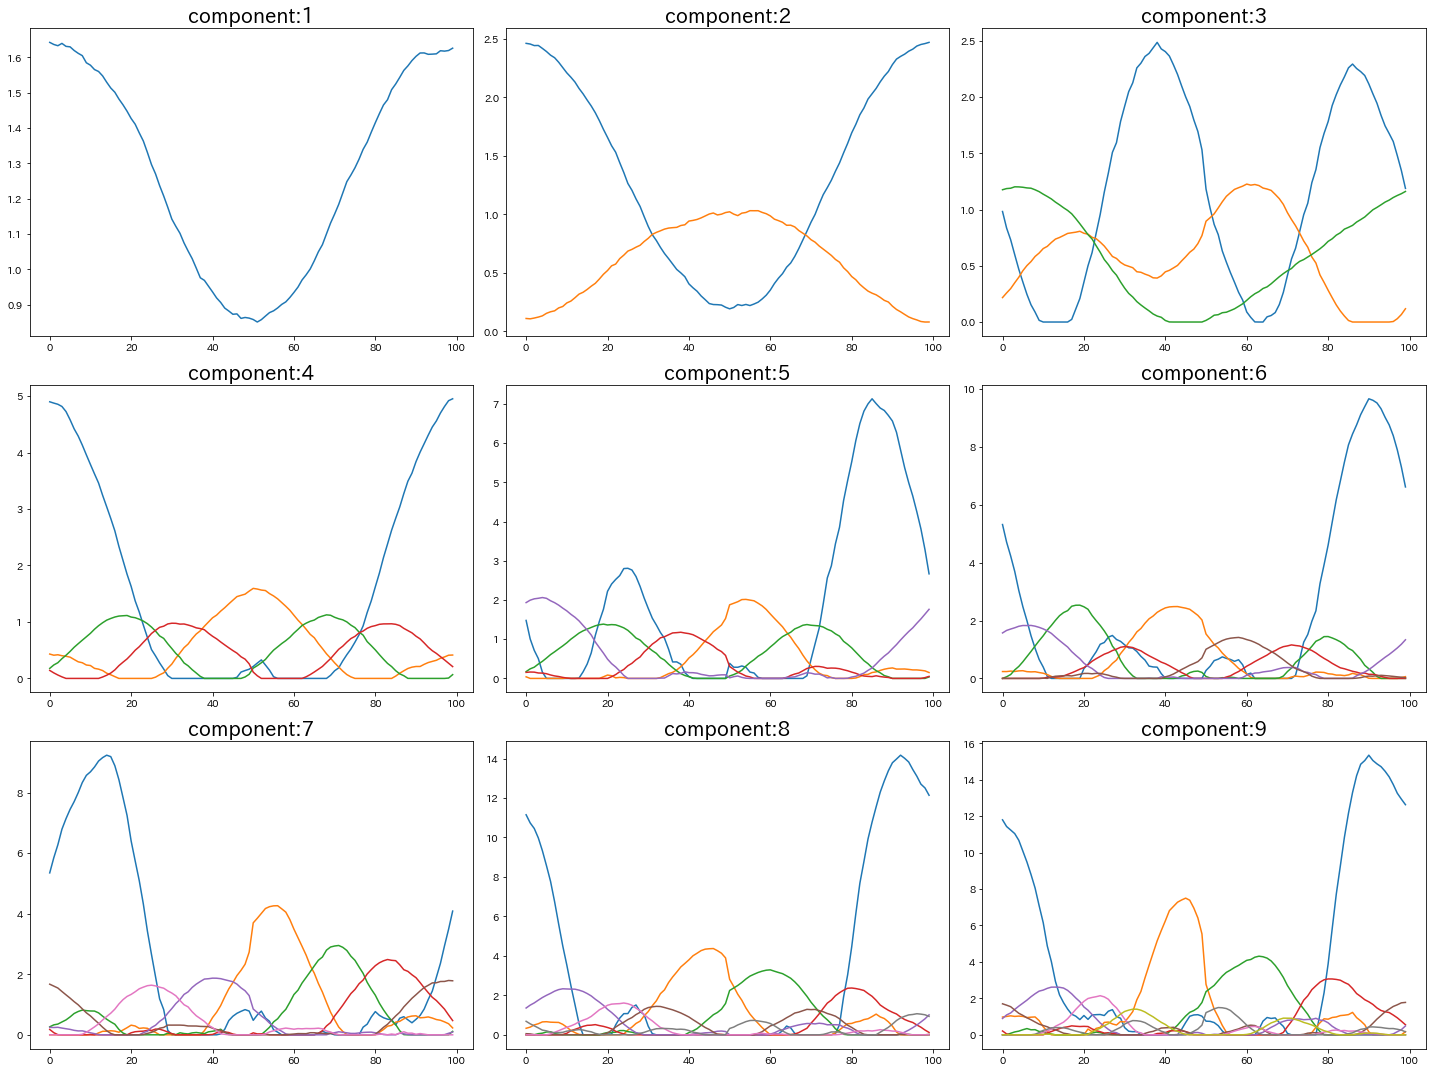

In [39]:
# コンポーネント数を変えて検証
nmf_models = []
for k in np.arange(1, 10):
    nmf = NMF(n_components=k)
    nmf.fit(alignment_A)
    nmf_models.append(nmf)
    
# 視覚化
plt.figure(figsize=(20, 15))
for i in np.arange(len(nmf_models)):
    for j in np.arange(len(nmf_models[i].components_)):
        ax = plt.subplot(3, 3, i+1)
        ax.plot(nmf_models[i].components_[j])
    ax.set_title(f'component:{j+1}', fontsize=20)
plt.tight_layout()
plt.show()